# 02936 Bayesian Data Analysis
## Extending Bepipred epitope prediction model
#### by Jakob Nissen (s170001) and Dennis Pohl (s190347)
## Introduction
In this project, we're exploring Bayesian extensions of an existing deep learning model, Bepipred, which predicts a property of proteins. Understanding this necessitates a brief introduction to the structure of proteins as well as the function of Bepipred, which we will cover in the next chapters.

This project was done in loose collaboration with Birkir Reynisson (BR) and Martil Closter Jespersen (MCJ). We decided early in the project to split into two groups because smaller ground allow each group member to contribute more meaningfully. The data, the original Bepipred model and a description of the scientific problem was provided by MCJ. Early in the project, we held meetings with BR & MCJ to get an idea about possible approaches to the project. Other than sharing the data, the Bepipred model and the initial meetings, the two groups have worked completely independently.

### Proteins and amino acids
Most biochemical reactions in the body are catalyzed by proteins. Proteins also serve as building blocks of tissues such as hair, nails, skin and muscle. For this reason, almost all molecular biological object of study involves interaction of proteins.

Proteins are synthesized in the body as a linear polymer of a kind of small polar molecule called amino acids. In natural proteins, 20 different amino acids are used. Hence, the chemical structure of a protein can conventiently be perfectly represented as a linear string of letters from a 20-character alphabet, by convention "ACDEFGHIKLMNPQRSTVWY".

During and immediately after synthesis, this chain of amino acid begins to electrostatically interact with itself and the sorrounding water and ions. These forces fold the chain into a well-defined three-dimensional structure that is critical for the function of the protein. Although this process is deterministic for a given amino acid sequence, and relies on nothing other than the physiochemical properties of the protein chain, predicting the folding of an amino acid chain is one of the most fundamental unsolved problems in science.

### Antibodies and epitopes
Antibodies are a group of proteins that can specifically recognize and bind to different classes of antigens through epitope regions. Antigens are foreign proteins, polysaccharides or other molecules, often found on bacterial or viral surface structures that can enter our body and induce an immune response. Generally, the human body is capable of detecting antigens through B cells carrying antibodies on their surface which will recognize these epitope regions (usually 5-8 amino acids in length) on the surface of the antigen. However epitopes can fold into complex three dimensional conformations by e.g. forming covalent bonds, thereby impairing the efficiency of an antibody to recognize and bind to the antigen. If an antibody was able to bind to an epitope it will render the antigen harmless by e.g. blocking its surface, thereby preventing interactions with the antigen's target receptor.
blabla

### Bepipred
Bepipred is a computational tool developed by Martin Closter Jespersen (MCJ) to predict which amino acids of a protein constitute epitopes, taking only the amino acid sequence as input. The input is thus a string of length N of the 20-letter amino acid alphabet. The output is a vector of length N of the prediction score in \[0, 1), where 0 indicates low probability of the corresponding amino acid being an epitope.

Bepipred is a convolutional neural network, that predicts the score of each amino acid based on a sliding window of size 9, i.e. the data of the central amino acid for which the score is predicted, as well as the 4 flanking amino acids on each side. Each sliding window leads to a prediction independent of the other sliding windows in the protein. Bepipred uses the features `rsa`, `seq`, `q3` and `disorder` (described in the dataset section).

### Dataset
Our dataset is a JSON file containing 190 proteins. The dataset have been curated such that no protein share a close evolutionary relationship with any other from the dataset, nor with any protein that Bepipred has been trained on.

A total of 16 features per protein in the dataset is avaiable. We will focus on the attributes that are potentially relevant here:

__epitope__:
A vector of 1 where the amino acid is an epitope and 0 where it is not. These are the true labels.

__preds__:
A vector of floats \[0, 1) with the output of Bepipred

__disorder__:
A vector of floats \[0, 1) with the a score signifying the predicted freedom of movement of the given amino acid, where 0 indicates the amino acid is locked into place and 1 indicating the amino acid can move as freely as possible.

__q3__:
A string of characters from the alphabet "CHE", signifying the predicted local "secondary" structure classified in either coil (C), helix (H) og sheet (E).

__q3_prob__:
A vector of vectors, where each inner vector has three elements represents the probability of the local structure being coil, helix or sheet, respectively.

__rsa__:
The predicted relative exposed surface area of the amino acid. This is constrained in [0, 1], where 0 signifies an amino acid completely buried on the inside of the protein, and 1 signifying the amino acid free-floating in the solution.

__seq__:
A string of chracters from the alphabet "ACDEFGHIKLMNPQRSTVWXY" representing the amino acid sequence of the protein, as well as X for unknown amino acid.

#### Objectives of this project


In [2]:
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

In [3]:
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt

from math import log
from collections import Counter
from scipy.special import logit, expit

import sys
sys.path.append(PSIS_DIRECTORY)
import psis

In [4]:
with open(DATA_PATH) as file:
    data = json.load(file)

### Data preparation

Inspection of the data reveals that one protein contains one amino acid labeled 'X'. Since the sliding windows are predicted independently, we have decided to remove this amino acid instead of discarding the protein.

In [5]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

# Remove 'X' from all proteins they are present in
for protein in data:
    if 'X' in protein['seq']:
        x_positions = [i for i,n in enumerate(protein['seq']) if n == 'X']
        for k, v in protein.items():
            if not hasattr(v, "__len__") or len(v) != len(protein['seq']):
                continue
            newdata = [x for i,x in enumerate(v) if i not in x_positions]
            if isinstance(v, str):
                newdata = ''.join(newdata)
            protein[k] = newdata

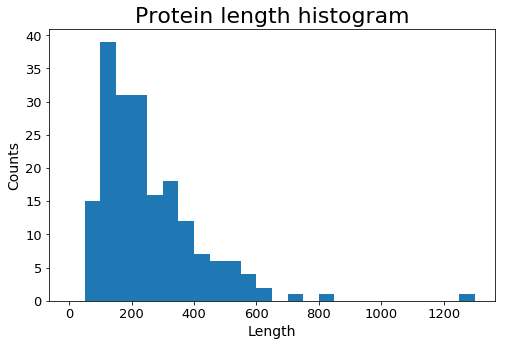

In [28]:
plt.figure(figsize=(8, 5))
plt.hist([len(protein['seq']) for protein in data], bins=np.linspace(0, 1300, 27));
setplot('Protein length histogram', 'Length', 'Counts')

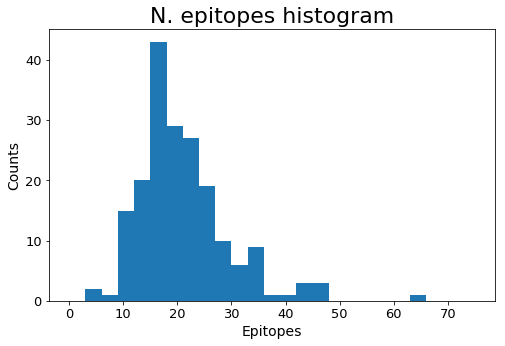

In [29]:
plt.figure(figsize=(8, 5))
plt.hist([sum(protein['epitope']) for protein in data], bins=np.linspace(0, 75, 26));
setplot('No. epitopes histogram', 'Epitopes', 'Counts')

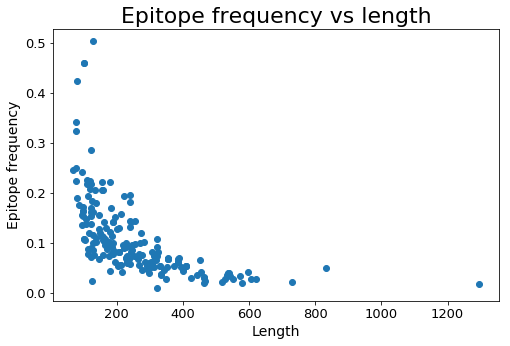

In [36]:
plt.figure(figsize=(8, 5))
plt.plot([len(i['epitope']) for i in data], [sum(i['epitope'])/len(i['epitope']) for i in data], 'o')
setplot('Epitope frequency vs length', 'Length', 'Epitope frequency')

In [40]:
counts = Counter()
epitopes = Counter()
for protein in data:
    for aa, isepitope in zip(protein['seq'], protein['epitope']):
        counts[aa] += 1
        if isepitope:
            epitopes[aa] += 1
freq = {aa: epitopes[aa]/counts[aa] for aa in counts if aa != 'X'}

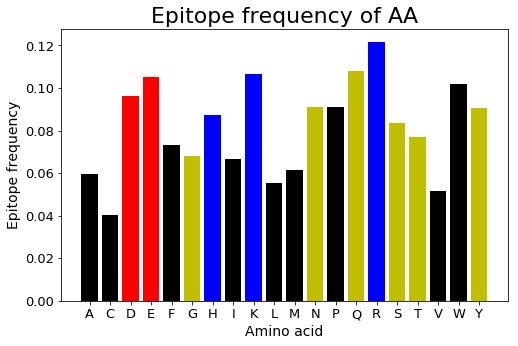

In [51]:
plt.figure(figsize=(8, 5))
ind = {aa:i for i, aa in enumerate(sorted(freq))}
aasets = [('GSTYNQ', 'y'),
         ('ACFILMVWP', 'k'),
         ('DE', 'r'),
         ('RHK', 'b')]
for aaset, color in aasets:
    for aa in aaset:
        plt.bar(ind[aa], freq[aa], color=color)
plt.xticks(range(len(freq)), sorted(freq))
setplot('Epitope frequency of AA', 'Amino acid', 'Epitope frequency')

NameError: name 'standata' is not defined

## Analysis

#### Null model

$epitopes \sim uniform(\alpha)$ 

For a baseline, we simply predict a constant probability of each amino acid being an epitope. Hopefully, all models should oerform better than this.

#### Model 0: Bepipred model

$epitopes \sim uniform(predictions)$

As the purpose of our project is to enhance Bepipred's prediction, the second baseline to establish is a model which simply interpretates Bepipreds output scores as probabilities. Building a model to beat the performance of this baseline is the true goal of the project. 

#### Model 1: Logistic model

$epitopes \sim expit(\alpha + \beta \times predictions)$

Bepipred is a deep neural network, and is therefore fitted to minimize some loss function which is not necessarily related to the log likelihood. The next step towards a probabilistic model is a simple logistic regression that uses only Bepipreds output to calculate a probability of an amino acid being an epitope.

#### Model 2: Separate model

$epitopes \sim expit(\alpha_{aa} + \beta_{aa} \times pred)$

The separate model does not include any pooling and will generate an estimate for each amino acid. This model will treat the amino acids independently from each other, means each amino acid estimate is unbiased and only based on its own <span style="color:red">(prediction score)</span>. This model has two parameters ($\alpha$ and $\beta$) for each amino acid estimate.

#### Model 3: Hierarhical model

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred)$

This model is an extension of the previous, where we assume the different $\alpha$ values are not truly independent, but in fact related by being from the same distribtuion, and thus can inform each other.

#### Model 4: Custom model

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred + \gamma \times \frac{1}{len})$

This model is identical to the previous model, except that a term is added to the logistic regression which takes the length of the protein into account.
Studying the data, we can see that the long proteins have fewer epitopes per amino acid than short ones do (see figure below). The signal is remarkable, and because Bepipred predicts on only a small window of amino acids, we believe it is not able to take this into account.

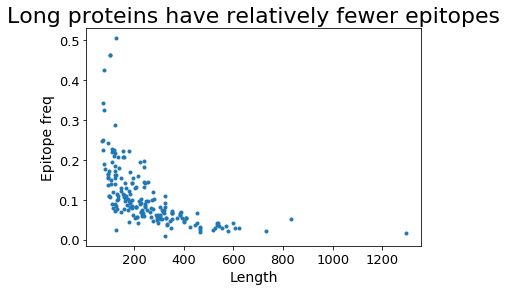

In [54]:
xs = [len(protein['seq']) for protein in data]
ys = [sum(protein['epitope'])/i for protein, i in zip(data, xs)]
plt.plot(xs, ys, '.')
setplot('Long proteins have relatively fewer epitopes', 'Length', 'Epitope freq')

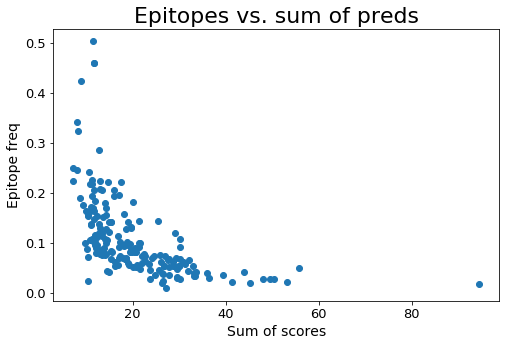

In [62]:
plt.figure(figsize=(8,5))
xs = [sum(protein['preds']) for protein in data]
ys = [sum(protein['epitope'])/len(protein['seq']) for protein, i in zip(data, xs)]
plt.plot(xs, ys, 'o')
setplot('Epitopes vs. sum of preds', 'Sum of scores', 'Epitope freq')

#### Model 6: Custom model

#### Model 7:

$epitopes \sim \gamma + \delta(1 - \gamma) \times \frac{1}{length} \times expit(\alpha_{aa} + \beta_{aa} \times pred)$




## Overview of results
blabla

## Conclusion
blabla

In [37]:
1/200

0.005

In [27]:
def setplot(title, xlabel, ylabel):
    plt.title(title, fontsize=22)
    plt.tick_params(labelsize=13)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)